In [1]:
#required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH


## Read Worldscope Global- Fundamental Annuals Data
path = 'data.csv'
data = pd.read_csv(path,
                   index_col=False,
                   sep = ',')
initial_data = data.shape
print('Initial data:', data.shape)

## Read World Bank Shareholder Rights IndexData
path_2 = 'shareholder_rights_data.csv'
shareholder_rights_data = pd.read_csv(path_2,
                                      index_col=False,
                                      sep = ',',
                                      encoding='latin1')


Initial data: (316647, 12)


In [2]:
#Rename columns to increase readability
data = data.rename(columns={'fic': 'country_code',
                            'costat': 'company_status',
                            'gvkey': 'company_key',
                            'gsector': 'gic_sector',
                            'at': 'total_assets',
                            'oancf': 'operating_cash_flow',
                            'oiadp': 'operating_income'})

#rename columns to ease working
shareholder_rights_data = shareholder_rights_data.rename(columns={'2019 [YR2019]': 'shareholder_rights_index',
                                                                  'Country Code': 'country_code',
                                                                  'Country Name':'country_name'})

#Drop columns that are not required
data = data.drop(columns= ['datafmt', 'indfmt','consol','datadate'])

In [3]:
#Merging shareholder rights index into the dataset
data = data.merge(shareholder_rights_data[['country_code','shareholder_rights_index','country_name']],
                  on='country_code',
                  how='left')

**Dropping N/A Observations**

In [4]:
def clean_df(data:pd.DataFrame,
             col_names:list) -> pd.DataFrame:
  '''
  Drops N/A values from columns used in earnings smoothing measure calculation.

  Parameters:
  -----------

  data:pd.DataFrame
    Dataset with N/A values

  col_names:list
    List for columns that need to be cleaned from N/A values

  Returns:
  --------

  data:pd.DataFrame
    Data frame cleaned from observations with N/A values in columns used in calculations

  '''

  total_dropped = []
  print('Initial data shape:', data.shape)

  for i in col_names:
    dropped_count = data[i].isna().sum()
    data = data.dropna(subset = [i])
    total_dropped.append(dropped_count)
    print(f'Dropping N/A values from {i}:' )
    print(f'Number of dropped observations: {dropped_count}')
    print(f'Shape after dropping N/A values in {i} {data.shape} \n')

  print(f'Number of total observations dropped: {sum(total_dropped)}')
  print(f'{sum(total_dropped)/initial_data[0]*100:.2}% percentage of observations dropped from initial dataset')

  return data


In [5]:
#Using clean_data function to clean the dataset from N/A observations in necessary columns
columns = ['operating_cash_flow', 'operating_income','shareholder_rights_index']
data = clean_df(data=data, col_names=columns)

Initial data shape: (316647, 10)
Dropping N/A values from operating_cash_flow:
Number of dropped observations: 5765
Shape after dropping N/A values in operating_cash_flow (310882, 10) 

Dropping N/A values from operating_income:
Number of dropped observations: 2403
Shape after dropping N/A values in operating_income (308479, 10) 

Dropping N/A values from shareholder_rights_index:
Number of dropped observations: 19179
Shape after dropping N/A values in shareholder_rights_index (289300, 10) 

Number of total observations dropped: 27347
8.6% percentage of observations dropped from initial dataset


**Ensure 300 Firm-Years for each Country**

Dropping countries and firms from the data that does not meet the following requirements:

*   Each firm should have at least 3 years of observations
*   Each country should haveat least 300 firm-year observations


In [7]:
def firm_year_requirements(data:pd.DataFrame,
                           min_year:int,
                           firm_year:int)-> pd.DataFrame:
  '''
  Ensuring each firm has minimum min_year years of observation.
  Ensuring each country has a minimum of 300 firm-year observation.
  Dropping countries and firms that does not meet these requirements.

  Parameters:
  -----------

  data:pd.DataFrame
    Dataset

  min_year:int
    Minimum years of observation required from each firm

  firm_year:int
    Minimum firm-year observation required for each country

  Returns:
  --------

  data_filtered:pd.DataFrame
    Data frame consisting of countries with a minimum 300 firm-year observation and firms that have at least min_year years of observation.

  '''

  #Dropping firms that have observations less than min_year condition from dataset

  total_companies = data['company_key'].unique()
  companies_keep = []

  for i in total_companies:
    num_years_i = data[data['company_key'] == i]['fyear'].nunique()
    if num_years_i >= min_year:
      companies_keep.append(i)
    else:
      pass

  data_year_filtered = data[data['company_key'].isin(companies_keep)]

  #Dropping countries that have less than 300 firm-year observations

  countries = data_year_filtered['country_code'].unique()
  countries_keep = []

  for i in countries:
    num_firm_year = data_year_filtered[data_year_filtered['country_code'] == i]['company_key'].count()
    if num_firm_year >= firm_year:
      countries_keep.append(i)
    else:
      pass

  data_filtered = data_year_filtered[data_year_filtered['country_code'].isin(countries_keep)]

  return data_filtered

data_filtered = firm_year_requirements(data=data, min_year=3, firm_year = 300)

In [8]:
data_filtered.shape

(282094, 10)

**Calculating EM1**

In [9]:
#Dropping company_key == 290132 from the dataset as it has 0 standard deviation for operating cash flow
data = data_filtered[data_filtered['company_key'] != 290132]


In [10]:
#The countries that we are working with after cleaning and filtering the dataset
print('Number of unique countries in the dataset:', len(data['country_code'].unique()))
countries = data['country_code'].unique()
countries

Number of unique countries in the dataset: 62


array(['NLD', 'ISR', 'PHL', 'GBR', 'JPN', 'SWE', 'AUS', 'MYS', 'DNK',
       'NOR', 'NZL', 'ESP', 'FRA', 'LUX', 'IRL', 'ITA', 'HKG', 'CHE',
       'ZAF', 'DEU', 'BRA', 'SGP', 'MEX', 'CHL', 'FIN', 'ARG', 'CHN',
       'IDN', 'RUS', 'KOR', 'PRT', 'TWN', 'PER', 'IND', 'BEL', 'AUT',
       'THA', 'GRC', 'JAM', 'TUR', 'POL', 'BGR', 'HRV', 'ARE', 'CYP',
       'COL', 'LKA', 'JOR', 'KEN', 'NGA', 'PAK', 'MAR', 'ZWE', 'ROU',
       'EGY', 'TUN', 'KWT', 'BGD', 'MUS', 'OMN', 'SAU', 'VNM'],
      dtype=object)

In [11]:
def earnings_smoothing(country_name:str,
                       dataset:pd.DataFrame = data
                       ) -> float:
  '''
  Calculates earnings smoothing score for each company in a country.

  Earnings smoothing score of each company is the standard deviation of operating income
  scaled by the standard deviation of operating cash flow.

  Country measure equals the median value of the companies in that country

  Parameters:
  -----------
  country_name:str
    The country for which the earnings smoothing score is calculated

  Returns:
  --------
  country_em:float
    The median value of the earnings smoothing measures across companies
  '''

  country_data = dataset[dataset['country_code']== country_name]
  companies = country_data['company_key'].unique()

  rows = []

  for i in companies:
    company_i = country_data[country_data['company_key']==i]
    op_income_std = company_i['operating_income'].std()
    cf_std = company_i['operating_cash_flow'].std()

    rows.append({
        'company_key' : i,
        'op_income_std' : op_income_std,
        'cf_std' : cf_std,
        'em' : op_income_std / cf_std
    })

  em_df = pd.DataFrame(rows)
  country_em = em_df['em'].median()

  return country_em


In [12]:
#Earnings Smoothing Measure Across Countries

rows = []
for i in countries:
  measure = earnings_smoothing(i)
  rows.append({
      'country_code' : i,
      'country_name': data.loc[data['country_code'] == i, 'country_name'].iloc[0],
      'earnings_smoothing': measure
  })

df = pd.DataFrame(rows)
df_sorted = df.sort_values(by='earnings_smoothing', ascending=False)
df_sorted.head(20)

,country_code,country_name,earnings_smoothing
52,ZWE,Zimbabwe,1.547785
6,AUS,Australia,1.173738
22,MEX,Mexico,0.934105
3,GBR,United Kingdom,0.927491
18,ZAF,South Africa,0.922681
8,DNK,Denmark,0.921466
5,SWE,Sweden,0.916927
20,BRA,Brazil,0.905859
25,ARG,Argentina,0.901059
54,EGY,"Egypt, Arab Rep.",0.890406


In [13]:
#Creating table for earnings smoothing measure across countries

doc = Document()

table_df = df_sorted[['country_name', 'earnings_smoothing']].reset_index(drop=True)
table_df['earnings_smoothing'] = table_df['earnings_smoothing'].round(3)

# Set sections to a narrower margin to help everything fit
section = doc.sections[0]
section.left_margin = section.right_margin = Pt(50)

# Prepare the data for a 4-column layout (Country, Measure, Country, Measure)
# We split the dataframe into two halves
half = (len(table_df) + 1) // 2
left_half = table_df.iloc[:half].reset_index(drop=True)
right_half = table_df.iloc[half:].reset_index(drop=True)

# 3. Create a table with 4 columns
table = doc.add_table(rows=1, cols=4)
table.style = 'Table Grid' # Optional: change to match your report style

# Define headers
headers = ['Country', 'Measure', 'Country', 'Measure']
for i, text in enumerate(headers):
    table.rows[0].cells[i].text = text

# 4. Fill the table
for i in range(half):
    cells = table.add_row().cells

    # Left side data
    cells[0].text = str(left_half.iloc[i]['country_name'])
    cells[1].text = str(left_half.iloc[i]['earnings_smoothing'])

    # Right side data (check if index exists since right_half might be shorter)
    if i < len(right_half):
        cells[2].text = str(right_half.iloc[i]['country_name'])
        cells[3].text = str(right_half.iloc[i]['earnings_smoothing'])

# 5. Make the font smaller to ensure it fits one page
for row in table.rows:
    for cell in row.cells:
        for paragraph in cell.paragraphs:
            paragraph.runs[0].font.size = Pt(9)

doc.save('earnings_smoothing_compact.docx')

**Relationship Between Shareholder Rights and EM1**

In [14]:
#Merging shareholder rights index into the dataset
em1_shareholder_rights = df_sorted.merge(shareholder_rights_data[['country_code','shareholder_rights_index']],
                                          on='country_code',
                                          how='left')

em1_shareholder_rights

,country_code,country_name,earnings_smoothing,shareholder_rights_index
0,ZWE,Zimbabwe,1.547785,100.00000
1,AUS,Australia,1.173738,66.66667
2,MEX,Mexico,0.934105,83.33333
3,GBR,United Kingdom,0.927491,100.00000
4,ZAF,South Africa,0.922681,83.33333
...,...,...,...,...
57,KWT,Kuwait,0.635935,33.33333
58,ARE,United Arab Emirates,0.635663,66.66667
59,TUN,Tunisia,0.619508,66.66667
60,MAR,Morocco,0.595616,100.00000


In [15]:
em1_shareholder_rights.drop(columns=['country_name'])

,country_code,earnings_smoothing,shareholder_rights_index
0,ZWE,1.547785,100.00000
1,AUS,1.173738,66.66667
2,MEX,0.934105,83.33333
3,GBR,0.927491,100.00000
4,ZAF,0.922681,83.33333
...,...,...,...
57,KWT,0.635935,33.33333
58,ARE,0.635663,66.66667
59,TUN,0.619508,66.66667
60,MAR,0.595616,100.00000


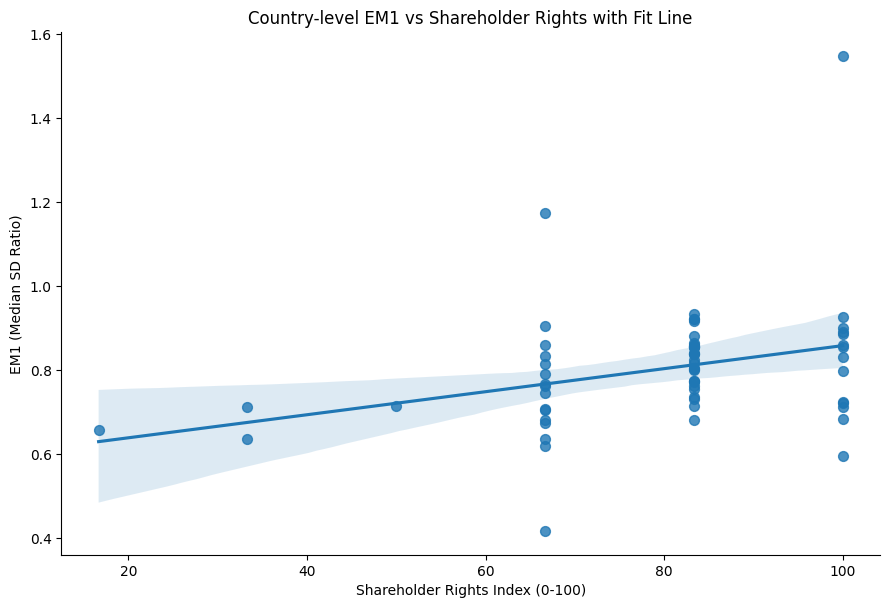

In [16]:
#Plotting the relationship between EM1 and Shareholder rights with a trend line
g = sns.lmplot(
    data=em1_shareholder_rights,
    x='shareholder_rights_index',
    y='earnings_smoothing',
    height=6,
    aspect=1.5,
    scatter_kws={'s':50}
)
plt.xlabel('Shareholder Rights Index (0-100)')
plt.ylabel('EM1 (Median SD Ratio)')
plt.title('Country-level EM1 vs Shareholder Rights with Fit Line')
g.savefig('em1_vs_shareholder_rights.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
import statsmodels.api as sm

X = em1_shareholder_rights['shareholder_rights_index']
X = sm.add_constant(X)
y = em1_shareholder_rights['earnings_smoothing']

model = sm.OLS(y, X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     earnings_smoothing   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     6.486
Date:                Sat, 31 Jan 2026   Prob (F-statistic):             0.0135
Time:                        16:10:49   Log-Likelihood:                 35.553
No. Observations:                  62   AIC:                            -67.11
Df Residuals:                      60   BIC:                            -62.85
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   